# Bubble Lab Test

This script looks into data recorded during DAS testing in UW's saltwater test tank where we produced bubbles in various rates.

In [100]:
# load modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import scipy
import os
import pandas as pd
import DASfuncs
import importlib

importlib.reload(DASfuncs)

<module 'DASfuncs' from '/Users/graeffd/Documents/projects/2022-25_SPI_GreenFjord/analysis/scripts/GreenFjord_DAS/DASfuncs.py'>

In [101]:
t_start = datetime.datetime(2023,6,1,22,55,20)
t_end = datetime.datetime(2023,6,1,22,56,20)

files = DASfuncs.get_Onyx_h5('../../../data/lab/SaltwaterTankTest/DAS_data/', t_start, t_end)
print('{} files in directory'.format(len(files)))

1 files in directory


In [102]:
# read the data
data_rec, t_rec, attrs = DASfuncs.read_Onyx_h5(files)#, cha_start=7, cha_end=-7)

In [104]:
# fill contiuous parts of data into array
time_list, data_list = DASfuncs.split_continuous_data(t_rec, data_rec, attrs)

In [105]:
# fill data gaps in array
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, data_list, attrs, t_format='datetime')
print('Data filles {:.2} GB of memory.'.format(sys.getsizeof(data_filled)/2**30))

Data filles 0.24 GB of memory.


Text(0.5, 0, 'Time [s]')

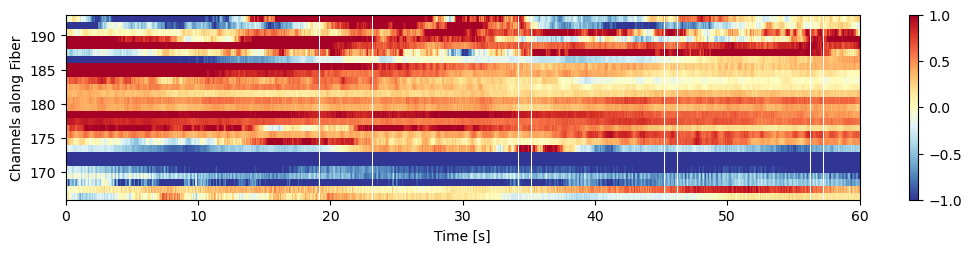

In [106]:
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))

# left plot
im = ax.imshow(data_filled.T, aspect='auto',
             origin='lower',
             vmin=-1,#np.percentile(data[~np.isnan(data)],5),
             vmax=1,#np.percentile(data[~np.isnan(data)],95),
             extent=[0,data.shape[0]/(attrs['PulseRate']), 
                  attrs['StartLocusIndex'],
                  attrs['StartLocusIndex']+data.shape[1]],
             cmap='RdYlBu_r',
             interpolation='none'
             )

cbar = plt.colorbar(im)
ax.set_ylabel('Channels along Fiber')
ax.set_xlabel('Time [s]')

In [107]:
# get data gaps
gap_list = DASfuncs.get_gaps(time_list, attrs)

Text(0.5, 0, 'Time')

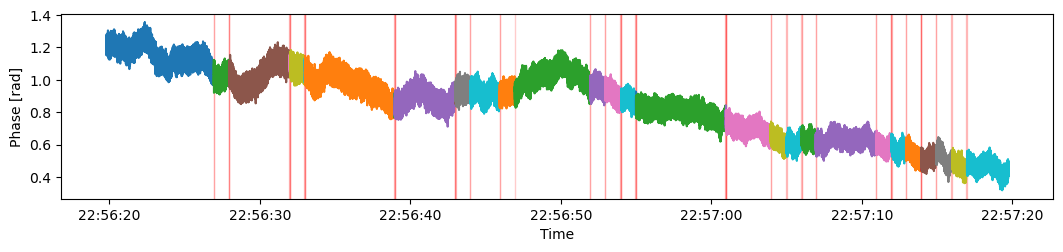

In [108]:
# plot time series with different colors indicating chunks of data
cha = 12
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))
for t, d in zip(time_list, data_list):
    # plt.plot(t,d[:,cha])
    # the convertion to datatime takes long...
    ax.plot(DASfuncs.sintela_to_datetime(t),d[:,cha]) # with datetime formatting
for gap in gap_list:
    # plt.axvspan(gap[0], gap[1], alpha=0.2, color='red')
    # the convertion to datatime takes long...
    ax.axvspan(DASfuncs.sintela_to_datetime(gap[0]), DASfuncs.sintela_to_datetime(gap[1]), alpha=0.2, color='red') # with datetime formatting
ax.set_ylabel('Phase [rad]')
ax.set_xlabel('Time')

In [130]:
# filtering
sos = scipy.signal.butter(2, (300,700),'bandpass', fs=attrs['PulseRate'], output='sos') # frequency in m
filt_list = [DASfuncs.apply_sosfiltfilt_with_nan(sos, arr, axis=0) for arr in data_list]

Text(0.5, 0, 'Time')

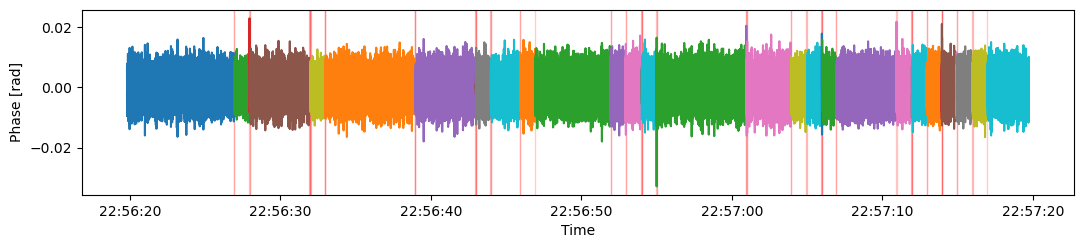

In [131]:
# plot filtered time series
cha = 14
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))
for t, d in zip(time_list, filt_list):
    # plt.plot(t,d[:,cha])
    # the convertion to datatime takes long...
    ax.plot(DASfuncs.sintela_to_datetime(t),d[:,cha]) # with datetime formatting
for gap in gap_list:
    # plt.axvspan(gap[0], gap[1], alpha=0.2, color='red')
    # the convertion to datatime takes long...
    ax.axvspan(DASfuncs.sintela_to_datetime(gap[0]), DASfuncs.sintela_to_datetime(gap[1]), alpha=0.2, color='red') # with datetime formatting
ax.set_ylabel('Phase [rad]')
ax.set_xlabel('Time')

In [132]:
# fill filtered data into array
_, data_filt = DASfuncs.fill_data_gaps(time_list, filt_list, attrs, t_format='datetime')

Text(0.5, 0, 'Time [s]')

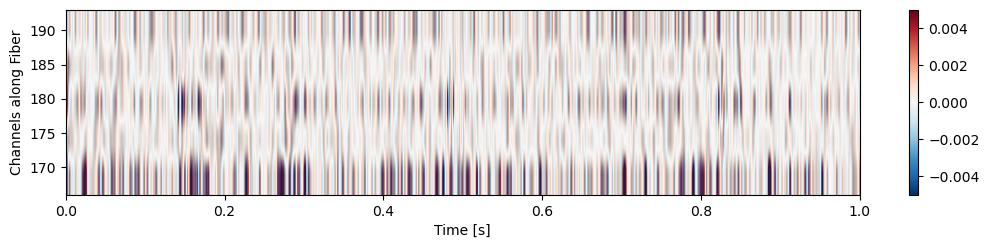

In [139]:
# plot filtered waterfall plot
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))
cha_start = 10
cha_end = 15
tstart = 0
tend = 1 # seconds
# left plot
im = ax.imshow(data_filt[int(attrs['PulseRate']*tstart):int(attrs['PulseRate']*tend),cha_start:cha_end].T, 
               aspect='auto',
             origin='lower',
             vmin=-0.005,#np.percentile(data[~np.isnan(data)],10),
             vmax=0.005,#np.percentile(data[~np.isnan(data)],90),
             extent=[tstart,tend, 
                  attrs['StartLocusIndex'],
                  attrs['StartLocusIndex']+data.shape[1]],
             cmap='RdBu_r',
             # interpolation='none'
             )

cbar = plt.colorbar(im)
ax.set_ylabel('Channels along Fiber')
ax.set_xlabel('Time [s]')

Text(0.5, 0, 'Time [s]')

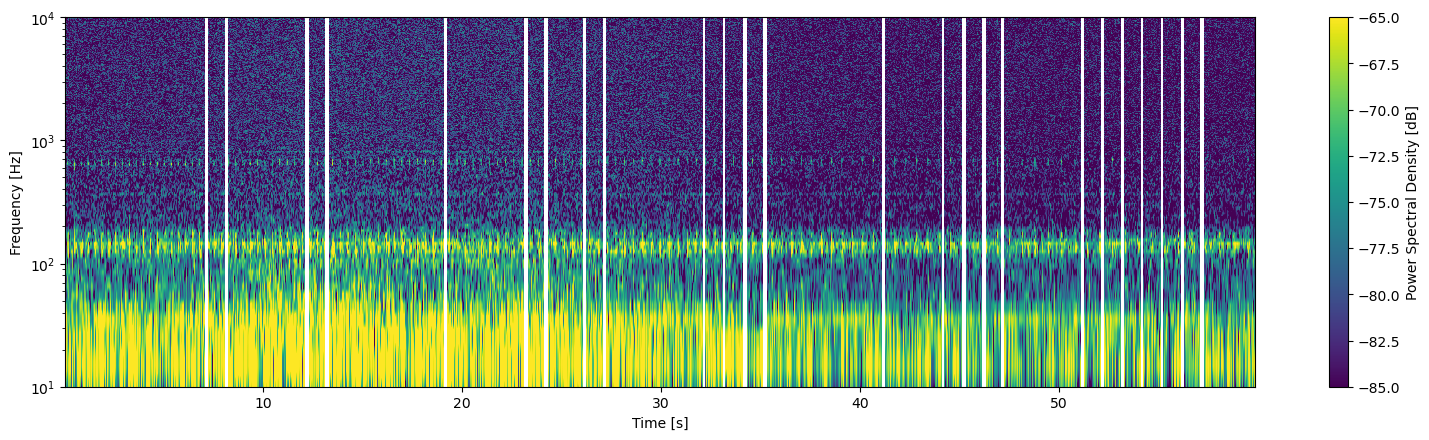

In [141]:
# plot a spectrogram of the median signal
spec_data = np.mean(data_filled[:,10:14], axis=1)

fs = attrs['PulseRate'] #sampling rate
NFFT = fs*0.1
fig, ax = plt.subplots(figsize=(3*6.4,4.8))
Pxx, freqs, bins, im = ax.specgram(spec_data, 
                                    Fs=fs,
                                    NFFT=int(NFFT),
                                    noverlap=int(NFFT/1.5),
                                    detrend='linear',   # detrending before taking fourier transform
                                    mode='psd',         # 'psd', 'magnitude', 'angle', 'phase'
                                    scale_by_freq=True, # unit/Hz
                                    scale='dB',
                                    vmax=-65, vmin=-85#, cmap='jet'
                                   )

cbar = plt.colorbar(im)
cbar.set_label('Power Spectral Density [dB]') #colorbar label
ax.set_ylim(10,10000)
ax.set_yscale('log')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')